# Exploration and Analysis of US's Clinical Care of Diabetes-Diagnosed Patients

In modern world, despite improved clinical treatments for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

In this notebook, we explore and analyse the dataset represeting ten years (1999-2008) of clinical care at 130 US hospitals and intergrated delivery network. Each record concerns a patient who is diagnosed with diabetes and underwent laboratory, medications, and hospitalization of 14-day maximization. The goal of the notebook is to determine the early readmission of the patient within 30 days of discharge.

The original datasets contains 101766 instances with 47 features including both categorical and integer types. The dataset can be obtained at: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

## Importing neccessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score

## Loading the data from local directory

The dataset is placed within the same directory with the notebook. The preview of the data is presented as follows using pandas functions and pandas DataFrame module.

In [2]:
hospital_data = pd.read_csv('diabetic_data.csv', header = [0], na_values = '?', dtype = {'payer_code': object})
hospital_data.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Admission type, discharge disposition, admission source are encoded in the dataset. Their labels are placed within 1 csv file called "IDS_mapping". Each mapping value can be obtained using parameters of pandas.read_csv() function

In [3]:
admission_mapping_data = pd.read_csv('IDS_mapping.csv', nrows = 8)
discharge_position = pd.read_csv('IDS_mapping.csv', nrows = 30, skiprows = 10)
admission_source = pd.read_csv('IDS_mapping.csv', nrows = 26, skiprows = 42)

The values from 3 encoded columns are mapped. The dataset's new structure is displayed below.

In [4]:
df = hospital_data.merge(admission_mapping_data, on = 'admission_type_id').merge(discharge_position, on = 'discharge_disposition_id', suffixes = ('_admission', '')).merge(admission_source, on = 'admission_source_id', suffixes = ('_discharge', '_admission_source'))
df.drop(['admission_type_id', 'discharge_disposition_id','admission_source_id'], axis = 'columns', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   encounter_id                  101766 non-null  int64 
 1   patient_nbr                   101766 non-null  int64 
 2   race                          99493 non-null   object
 3   gender                        101766 non-null  object
 4   age                           101766 non-null  object
 5   weight                        3197 non-null    object
 6   time_in_hospital              101766 non-null  int64 
 7   payer_code                    61510 non-null   object
 8   medical_specialty             51817 non-null   object
 9   num_lab_procedures            101766 non-null  int64 
 10  num_procedures                101766 non-null  int64 
 11  num_medications               101766 non-null  int64 
 12  number_outpatient             101766 non-null  int64 
 13 

## Cleaning Data

### Processing null values

We can check for the number of null values in each column compared to total number of records.

In [6]:
na_table = df.isna().sum() / df.shape[0]
na_table.sort_values(ascending = False)

weight                          0.968585
max_glu_serum                   0.947468
A1Cresult                       0.832773
medical_specialty               0.490822
payer_code                      0.395574
description_admission_source    0.066633
description_admission           0.051992
description_discharge           0.036269
race                            0.022336
diag_3                          0.013983
diag_2                          0.003518
diag_1                          0.000206
acarbose                        0.000000
troglitazone                    0.000000
tolazamide                      0.000000
examide                         0.000000
citoglipton                     0.000000
insulin                         0.000000
miglitol                        0.000000
glipizide-metformin             0.000000
glyburide-metformin             0.000000
pioglitazone                    0.000000
glimepiride-pioglitazone        0.000000
metformin-rosiglitazone         0.000000
metformin-piogli

As we can see, there are 5 columns having more than 40% of the dataset unrecored, which makes up over 40000 records for each column. weight and max_glu_serum even have more than 90000 values unrecorded and can be removed from the dataset. The following process gets all the columns that have the proportions of over 33% to remove them from the data set

In [7]:
drop_columns = na_table[na_table > 0.33].index.to_list()
df.drop(drop_columns, axis = 'columns', inplace = True)

The new dataset has 45 columns, meaning that 5 columns have been removed from the original.

In [8]:
df.shape

(101766, 45)

Every record containing null values can be deleted to decrease the size of the data as they don't comprise a considerable portion of the records. The new dataset has 85601 records as shown below.

In [9]:
df.dropna(inplace = True)
df

,encounter_id,patient_nbr,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_admission,description_discharge,description_admission_source
247,64269738,26431191,Other,Female,[50-60),3,22,2,21,0,...,No,No,No,No,No,Yes,NO,Urgent,Not Mapped,Physician Referral
248,81764628,392742,Caucasian,Female,[80-90),6,34,0,6,0,...,No,No,No,No,No,No,NO,Urgent,Not Mapped,Physician Referral
249,131643918,72221436,Caucasian,Female,[60-70),5,92,4,18,4,...,No,No,No,No,No,No,NO,Urgent,Not Mapped,Physician Referral
250,133693974,60467670,Caucasian,Female,[40-50),13,61,2,12,2,...,No,No,No,No,No,Yes,NO,Urgent,Not Mapped,Physician Referral
251,245651082,75136851,Caucasian,Female,[40-50),3,84,0,16,0,...,No,No,No,No,No,Yes,NO,Urgent,Not Mapped,Physician Referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,345401582,37459422,Caucasian,Female,[70-80),14,37,0,8,0,...,No,No,No,No,Ch,Yes,NO,Elective,Discharged/transferred to home with home healt...,Transfer from hospital inpt/same fac reslt in...
101762,375471290,87775947,AfricanAmerican,Female,[70-80),11,40,2,16,0,...,No,No,No,No,No,Yes,NO,Elective,Discharged/transferred to home with home healt...,Transfer from hospital inpt/same fac reslt in...
101763,384289598,58376619,Caucasian,Female,[80-90),13,53,0,12,0,...,No,No,No,No,Ch,Yes,NO,Elective,Discharged/transferred to home with home healt...,Transfer from hospital inpt/same fac reslt in...
101764,437253248,147593579,Caucasian,Female,[70-80),8,1,0,20,0,...,No,No,No,No,Ch,Yes,<30,Elective,Discharged/transferred to home with home healt...,Transfer from hospital inpt/same fac reslt in...


### Removing unique or homogeneous columns

Returning to the source of the data, we can get the definitions for encounter_id and patient_nbr. While encounter_id is unique identifier of an encounter, patient_nbr is unique identifier of a patient. Both values don't contribute to the construction of the predictive model and, therefore, are removed from the dataset.

In [10]:
df.drop(['encounter_id','patient_nbr'], axis = 'columns', inplace = True)

We can inspect the value counts of each categories as follows.

In [11]:
for column in df.select_dtypes(include = ['object']).columns:
    display(pd.crosstab(index = df[column], columns = '% observations', normalize = 'columns'))

col_0,% observations
race,
AfricanAmerican,0.199215
Asian,0.006425
Caucasian,0.761019
Hispanic,0.018212
Other,0.015128


col_0,% observations
gender,
Female,0.540286
Male,0.459703
Unknown/Invalid,0.000012


col_0,% observations
age,
[0-10),0.000701
[10-20),0.005082
[20-30),0.015794
[30-40),0.036588
[40-50),0.094006
[50-60),0.171610
[60-70),0.223782
[70-80),0.253595
[80-90),0.170909


col_0,% observations
diag_1,
10,0.000012
11,0.000117
110,0.000023
112,0.000771
114,0.000012
...,...
V60,0.000012
V63,0.000093
V66,0.000012


col_0,% observations
diag_2,
11,0.000035
110,0.000070
112,0.001928
114,0.000012
115,0.000012
...,...
V69,0.000012
V70,0.000082
V72,0.000140


col_0,% observations
diag_3,
11,0.000023
110,0.000175
111,0.000012
112,0.002103
115,0.000012
...,...
V66,0.000152
V70,0.000012
V72,0.000093


col_0,% observations
metformin,
Down,0.005584
No,0.801871
Steady,0.182416
Up,0.010128


col_0,% observations
repaglinide,
Down,0.000491
No,0.983131
Steady,0.015163
Up,0.001215


col_0,% observations
nateglinide,
Down,0.000117
No,0.992150
Steady,0.007488
Up,0.000245


col_0,% observations
chlorpropamide,
Down,0.000012
No,0.999416
Steady,0.000526
Up,0.000047


col_0,% observations
glimepiride,
Down,0.001974
No,0.945912
Steady,0.048948
Up,0.003166


col_0,% observations
acetohexamide,
No,0.999988
Steady,0.000012


col_0,% observations
glipizide,
Down,0.005374
No,0.874511
Steady,0.112826
Up,0.007290


col_0,% observations
glyburide,
Down,0.004918
No,0.901765
Steady,0.085852
Up,0.007465


col_0,% observations
tolbutamide,
No,0.999801
Steady,0.000199


col_0,% observations
pioglitazone,
Down,0.001051
No,0.926321
Steady,0.070350
Up,0.002278


col_0,% observations
rosiglitazone,
Down,0.000771
No,0.937442
Steady,0.060046
Up,0.001741


col_0,% observations
acarbose,
Down,0.000035
No,0.997068
Steady,0.002815
Up,0.000082


col_0,% observations
miglitol,
Down,0.000047
No,0.999603
Steady,0.000327
Up,0.000023


col_0,% observations
troglitazone,
No,0.999977
Steady,0.000023


col_0,% observations
tolazamide,
No,0.999778
Steady,0.000222


col_0,% observations
examide,
No,1.0


col_0,% observations
citoglipton,
No,1.0


col_0,% observations
insulin,
Down,0.124344
No,0.449282
Steady,0.310429
Up,0.115945


col_0,% observations
glyburide-metformin,
Down,0.000035
No,0.992208
Steady,0.007687
Up,0.000070


col_0,% observations
glipizide-metformin,
No,0.999848
Steady,0.000152


col_0,% observations
glimepiride-pioglitazone,
No,0.999988
Steady,0.000012


col_0,% observations
metformin-rosiglitazone,
No,1.0


col_0,% observations
metformin-pioglitazone,
No,0.999988
Steady,0.000012


col_0,% observations
change,
Ch,0.472086
No,0.527914


col_0,% observations
diabetesMed,
No,0.222953
Yes,0.777047


col_0,% observations
readmitted,
<30,0.112487
>30,0.354003
NO,0.533510


col_0,% observations
description_admission,
Elective,0.201189
Emergency,0.577587
Newborn,0.000117
Not Available,0.021098
Not Mapped,0.003645
Trauma Center,0.000234
Urgent,0.196131


col_0,% observations
description_discharge,
Admitted as an inpatient to this hospital,0.000222
Discharged to home,0.623649
Discharged/transferred to ICF,0.008703
Discharged/transferred to SNF,0.139917
Discharged/transferred to a federal health care facility.,0.000058
Discharged/transferred to a long term care hospital.,0.004428
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,0.000561
Discharged/transferred to another rehab fac including rehab units of a hospital .,0.022383
Discharged/transferred to another short term hospital,0.021028


col_0,% observations
description_admission_source,
Court/Law Enforcement,0.000164
Emergency Room,0.612575
Extramural Birth,0.000023
Not Available,0.000572
Not Mapped,0.001869
Physician Referral,0.314050
Sick Baby,0.000012
Transfer from Ambulatory Surgery Center,0.000023
Transfer from a Skilled Nursing Facility (SNF),0.008540


We realize that there are 706 unique values for diag_1, 723 unique values for diag_2, and 771 unique values for diag_3. The association of these categories can produce more than 300,000,000 distinguished combinations. Without proper medical knowledge to reduce the size of combinations, it is reasonable to remove them from the dataset.

In [12]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis = 'columns', inplace = True)

The result also displays 3 attributes (examide, citoglipton, and metformin-rosiglitazone) having the same value for all records, which make them valueless to the analysis and prediction and be cut out from the dataset.

In [13]:
df.drop(['examide', 'citoglipton', 'metformin-rosiglitazone'], axis = 'columns', inplace = True)

From the table, we perceive that the rate of patient not being readmitted is over 50% of the cases. While it is regarded that similar proportion are being readmitted, there are only 20% of the patients being readmitted are hospitalized within 30 days (11% of the total records). The distribution of the target is strongly uneven if we consider predicting the possibility that the patient is recharged within 30 days as intention of the notebook has stated.

### Removing outliers

The quantitative attributes of the dataset is shown as follows.

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,85601.000000,85601.000000,85601.000000,85601.000000,85601.000000,85601.000000,85601.000000,85601.000000
mean,4.389213,43.677072,1.348746,16.106588,0.379119,0.208385,0.650483,7.587680
std,2.977536,19.444097,1.708082,8.083833,1.310826,0.976062,1.277610,1.819328
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,33.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,45.000000,1.000000,15.000000,0.000000,0.000000,0.000000,9.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


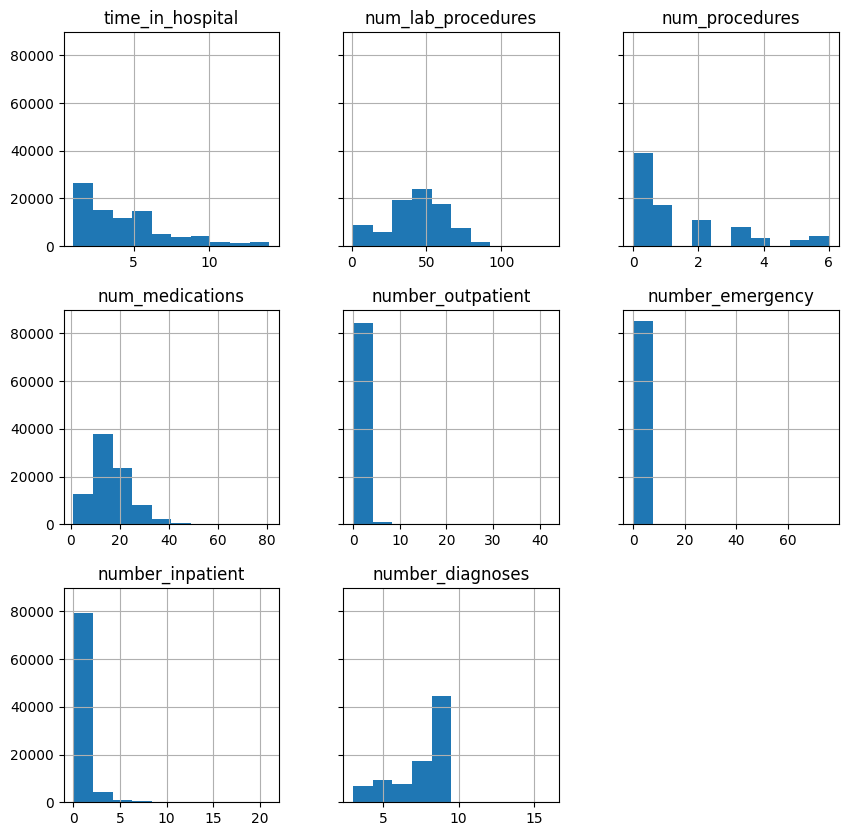

In [14]:
display(df.describe())

df.hist(bins = 10, sharey = True, figsize=(10, 10))
plt.show()

It can be seen from the visulization that there are several attibutes having extreme outliers that extend the range of the values such as number_outpatient, number_inpatient, and number_emergency. We can detect the outliers by calculating their z-score and compare them to a threshold. The threshold of deletion in this case is more than 3 standard deviations from the mean. 

In [15]:
for column in df.select_dtypes(include = ['int64']).columns:
    mean_value = df[column].mean()
    std_value = df[column].std()
    df.loc[:, 'z_score'] = np.abs((df[column] - mean_value) / std_value)
    df = df[df['z_score'] <= 3]
df.drop('z_score', axis = 'columns', inplace = True)
df.shape

(79979, 37)

The new dataset has 79979 records with 37 columns.

## Feature Engineering

We can visualize the correlations of the numeric columns in the table as a heatmap for easy detection and visualization. The following display presents it as scatter plots to articulate the number presented in the heat map.

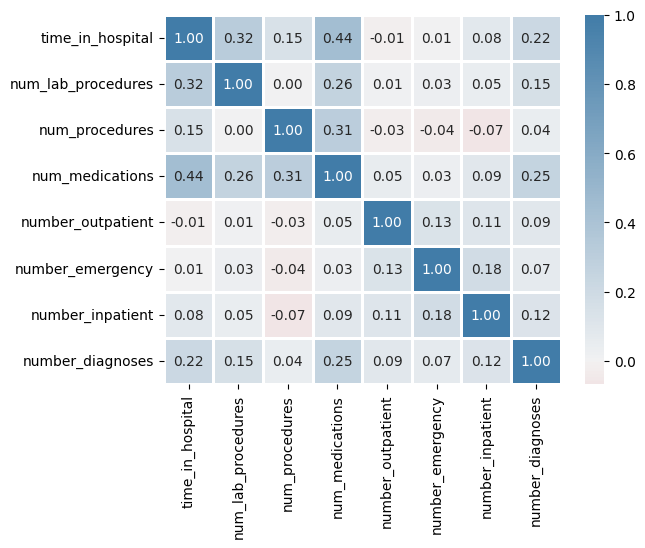

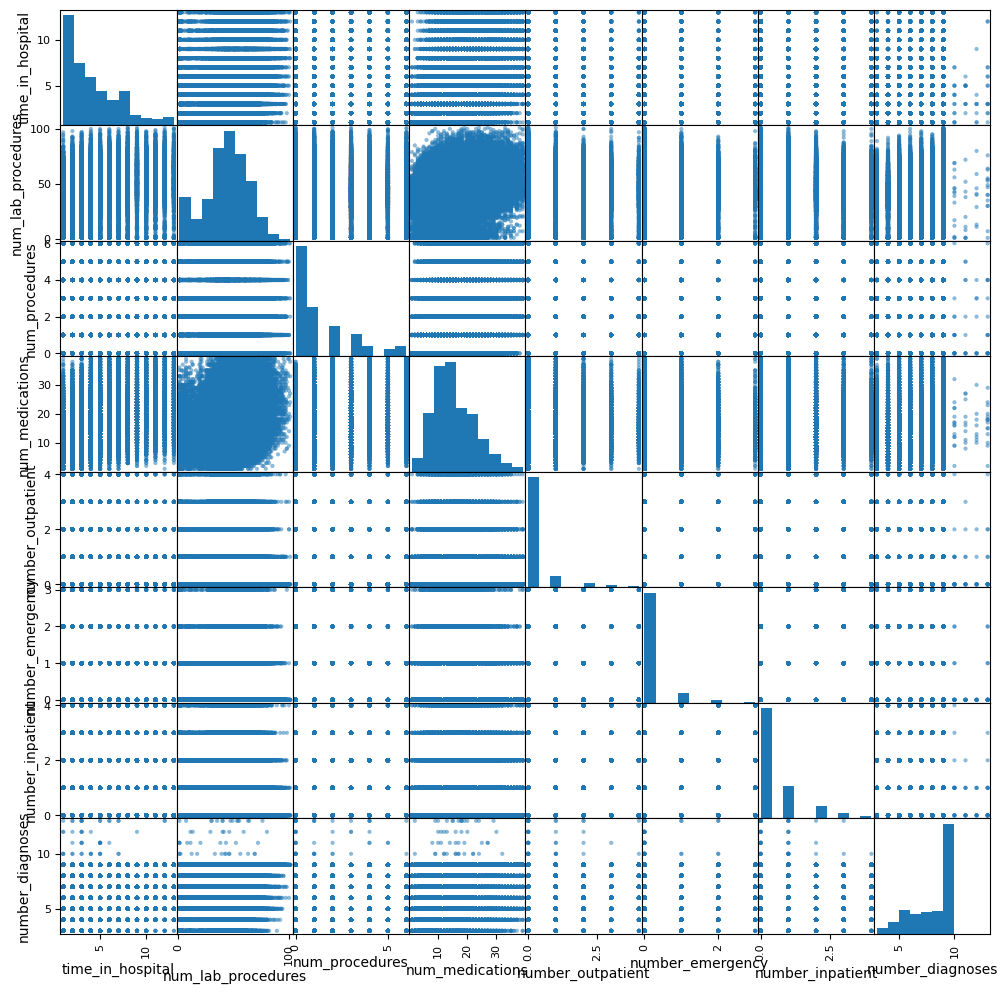

In [16]:
cmap = sns.diverging_palette(h_neg = 10, h_pos = 240, as_cmap=True)
sns.heatmap(df.corr(numeric_only = True), cmap = cmap, center = 0, linewidths = 1, annot = True, fmt='.2f')
pd.plotting.scatter_matrix(df, figsize = (12, 12))
plt.show()

From the visualizations, it is not difficult to realize that all quantitative attibutes in the table have low correlations with each other. The maximum degree of interdependence is 0.44 between num_medications and time_in_hospital. However, even this number is not high enough to remove any of them from the dataset. Consequently, all numeric attributes are kept for the analysis.

We can examine the independence between categorical attributes and readmitted (another categorical attribute) using chi-squared test.

In [17]:
result = pd.Series(dtype = float)
for column in df.select_dtypes(include = ['object']).columns:
    contingency_table = pd.crosstab(df[column], df['readmitted'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    result[column] = p
result.sort_values(ascending = False)

acetohexamide                    1.000000e+00
troglitazone                     8.390588e-01
nateglinide                      7.395579e-01
tolbutamide                      6.606498e-01
metformin-pioglitazone           6.588089e-01
glimepiride-pioglitazone         3.931220e-01
glipizide-metformin              3.569441e-01
glyburide-metformin              2.526196e-01
tolazamide                       2.525135e-01
chlorpropamide                   2.265974e-01
miglitol                         1.341942e-01
glyburide                        1.088348e-01
glimepiride                      2.574051e-02
rosiglitazone                    2.892748e-04
gender                           2.504269e-04
acarbose                         1.369372e-04
pioglitazone                     3.395925e-05
glipizide                        1.939004e-09
repaglinide                      3.880622e-10
metformin                        1.799714e-10
race                             1.376835e-23
change                           4

The significance level of the statistic test is chosen to be 1%, meaning that every attribute has p-value higher than 0.01 will be deleted from the dataset as they prove that the null hypothesis, there is no relationship between two variables, is true. The folloing code filters these columns to remove them from the dataset

In [18]:
df.drop(result[result > 0.01].index.to_list(), axis = 'columns', inplace = True)
df.shape

(79979, 24)

The subsequent process investigates the importance of the features to the final result using Random Forest Classification. Even though the shape of the dataset has been reduced to 24 columns, the number can still be lowered to avoid overcomplication in later deployment. 

All categorical attributes must be transformed into numeric form. As they are nominal, or no order presented, it is reasonable to use one-hot encoding for transformation. The result can easily be obtained using pandas get_dummies function

In [19]:
X = df.drop(['readmitted'], axis = 'columns')
y = df['readmitted']
X = pd.get_dummies(X)
X.shape

(79979, 102)

The process also examines the performace of the model, so train datasets and test datasets must be obtained.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 188, train_size = 0.8)

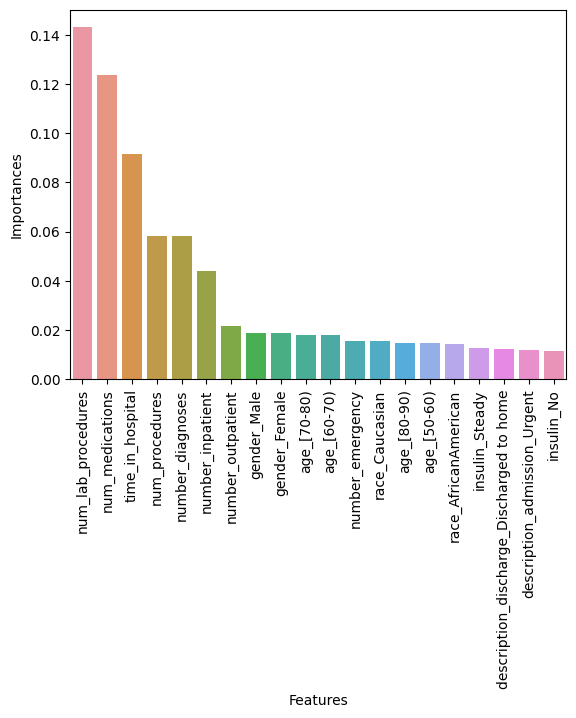

In [21]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

feature = pd.DataFrame({'Features': X.columns, 'Importances': rfc.feature_importances_})
feature = feature.sort_values('Importances', ascending = False).iloc[:20, :]
sns.barplot(x = 'Features', y = 'Importances', data = feature)
plt.xticks(rotation=90)
plt.show()

From the above display, it is noticed that all numeric columns have a high rank in the determination of the prediction. Gender, age, and race also placed in front with several dummies columns on top. Therefore, these columns are retained.

In [23]:
X = df[df.select_dtypes(include = ['int64']).columns.to_list() + ['gender', 'age', 'race']]
X

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,gender,age,race
247,3,22,2,21,0,0,0,9,Female,[50-60),Other
248,6,34,0,6,0,0,0,5,Female,[80-90),Caucasian
249,5,92,4,18,4,0,1,9,Female,[60-70),Caucasian
250,13,61,2,12,2,0,1,9,Female,[40-50),Caucasian
251,3,84,0,16,0,0,0,9,Female,[40-50),Caucasian
...,...,...,...,...,...,...,...,...,...,...,...
101759,10,36,0,19,0,0,1,9,Female,[80-90),Caucasian
101760,12,39,0,27,1,1,4,8,Female,[60-70),Caucasian
101762,11,40,2,16,0,0,1,9,Female,[70-80),AfricanAmerican
101763,13,53,0,12,0,0,1,8,Female,[80-90),Caucasian


In [22]:
accuracy_score(rfc.predict(X_test), y_test)

0.563953488372093

The model has accuracy score of 56%. This is not a high number, but considering the correction rate of 33.33% of random guess between 3 available classes, it is not unacceptable.

We can scale all the columns in the acquired dataset using Standard Scaler. The transformation is performed in order to obtain a better result from the model. The dataset will be converted into float dtypes (one-hot encoding) before being fed to the scaler.

In [24]:
scaler = StandardScaler()

X = scaler.fit_transform(pd.get_dummies(X))

X.shape

(79979, 26)

The new dataset has 26 attributes, which is considerable. We can minimize this number using PCA (Principal Component Analysis). However, as there is no definition of the best number of attributes to downsize, we can utilize explained_variance_ratio_ attribute of the object to choose an appropriate number.

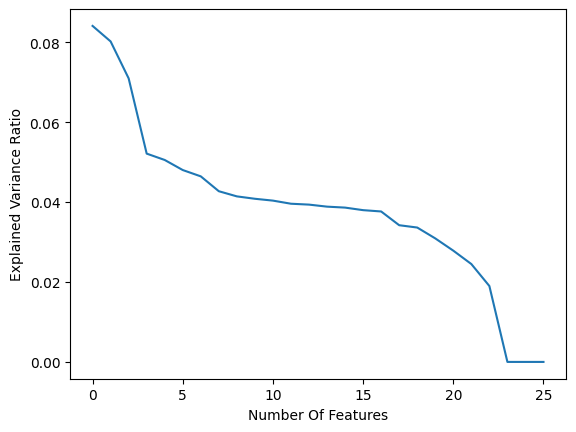

In [25]:
pca = PCA()

pca.fit(X)

var = pca.explained_variance_ratio_

plt.plot(var)

plt.xlabel('Number Of Features')
plt.ylabel('Explained Variance Ratio')

plt.show()

Usually, we will look for an elbow point to choose the number of components to size down. However, from the visualization, we can not obtain a such number to cut down. Therefore, we will keep the original scaled dataset.

## Predictive Models

From the processed dataset, we can start building predictive models to predict if a patient is readmitted.

The target column has data type of object, therefore, it is encoded with label before being used.

In [26]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, train_size=0.8, random_state=188)

The model being used is XGBoost Classifier. This is a decent model that has proved to provide a high accuracy and performace. The parameters of the model are chosen carefully to achieve highest performance.

In [27]:
# Convert the NumPy arrays to DMatrix objects, which are optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define hyperparameters
params = {
    'objective': 'multi:softmax',  # for multi-class classification
    'num_class': 3,  # number of classes
    'max_depth': 10,                 # maximum depth of the tree
    'eta': 0.05                     # learning rate
}

num_round = 200  # Number of boosting rounds

# Train the XGBoost model
model = xgb.train(params, dtrain, num_round)

# Predict on the test set
y_pred = model.predict(dtest)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.56


However, the model has the same accuracy with Random Forest Classification, proving that using Decision Tree is not appropriate in this case.

The process of building this model has proved that Random Forest and XGBoost are not suitable models for this dataset. For future work, we can consider choosing a different model that has higher efficiency, such as ANN, or Artifical Neuron Network, which is provided by tensorflow library. The layers of the model can be considered with careful inspection to improve the performance of the predictions.